# Bloom Filter Project

This notebook demonstrates the complete implementation and analysis of a Bloom Filter. We will cover data generation, Bloom Filter implementation, hash functions, testing, benchmarking, and visualizing results.

## Step 1: Data Generation

First, we generate different types of datasets that will be used for testing our Bloom Filter. These include random strings, natural language words, DNA sequences, and email addresses.


In [1]:
# Required Libraries
import json
import time
import psutil
import random
import string
import os
import unittest
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Data Generation

# Define the number of elements in the datasets
NUM_ELEMENTS = 10 ** 4

# Generate random strings related to computer science
def generate_random_strings(file_path, num_strings, length=10):
    keywords = ["algorithm", "binary", "compiler", "data", "encryption", "function", "hardware", "interface", "java", "kernel", "library", "memory", "network", "object", "protocol", "queue", "recursion", "syntax", "thread", "variable"]
    with open(file_path, 'w') as f:
        for _ in range(num_strings):
            rand_str = ''.join(random.choices(keywords, k=1)) + ''.join(random.choices(string.ascii_lowercase, k=length - 1))
            f.write(rand_str + '\n')

# Generate natural language words related to data science
def generate_natural_language_words(file_path, num_words):
    words = ["data", "science", "machine", "learning", "model", "algorithm", "statistics", "analysis", "big", "data", "mining", "predictive", "analytics", "visualization", "clustering", "classification", "regression", "python", "r", "sql"]
    with open(file_path, 'w') as f:
        for _ in range(num_words):
            f.write(random.choice(words) + '\n')

# Generate real-world DNA sequences
def generate_dna_sequences(file_path, num_sequences, length=10):
    nucleotides = ['A', 'T', 'C', 'G']
    with open(file_path, 'w') as f:
        for _ in range(num_sequences):
            seq = ''.join(random.choices(nucleotides, k=length))
            f.write(seq + '\n')

# Generate email addresses with specific domains
def generate_email_addresses(file_path, num_addresses):
    domains = ["hotmail.com", "outlook.com", "gmail.com", "uhasselt.be", "kuleuven.be"]
    with open(file_path, 'w') as f:
        for _ in range(num_addresses):
            user = ''.join(random.choices(string.ascii_lowercase, k=5))
            domain = random.choice(domains)
            f.write(user + "@" + domain + '\n')

if __name__ == "__main__":
    os.makedirs("data", exist_ok=True)
    generate_random_strings("data/random_strings.txt", NUM_ELEMENTS)
    generate_natural_language_words("data/natural_language_words.txt", NUM_ELEMENTS)
    generate_dna_sequences("data/dna_sequences.txt", NUM_ELEMENTS)
    generate_email_addresses("data/email_addresses.txt", NUM_ELEMENTS)


## Step 2: Bloom Filter Implementation

Next, we implement the Bloom Filter and associated hash functions. The Bloom Filter uses a bitset to store hashed values and multiple hash functions to minimize the chance of collisions.


In [6]:
# Bloom Filter Implementation

class BitSet:
    def __init__(self, size):
        self.size = size
        self.bitset = [0] * ((size // 64) + 1)

    def add(self, index):
        self.bitset[index // 64] |= (1 << (index % 64))

    def contains(self, index):
        return (self.bitset[index // 64] & (1 << (index % 64))) != 0

import hashlib
import mmh3
import cityhash

class HashFunctions:
    @staticmethod
    def hash_int32_jenkins(key):
        if isinstance(key, str):
            key = key.encode('utf-8')
        hash_value = 0
        for char in key:
            hash_value += char
            hash_value += (hash_value << 10)
            hash_value ^= (hash_value >> 6)
        hash_value += (hash_value << 3)
        hash_value ^= (hash_value >> 11)
        hash_value += (hash_value << 15)
        return hash_value & 0xffffffff

    @staticmethod
    def hash_int32_shift(key):
        if isinstance(key, str):
            key = key.encode('utf-8')
        hash_value = 0
        for char in key:
            hash_value = (hash_value << 5) - hash_value + char
        return hash_value & 0xffffffff

    @staticmethod
    def hash_murmur(key):
        if isinstance(key, str):
            key = key.encode('utf-8')
        return mmh3.hash(key)

    @staticmethod
    def hash_city(key):
        if isinstance(key, str):
            key = key.encode('utf-8')
        return cityhash.CityHash32(key)

    @staticmethod
    def hash_sha256(key):
        if isinstance(key, str):
            key = key.encode('utf-8')
        return int(hashlib.sha256(key).hexdigest(), 16) % (1 << 32)

    @staticmethod
    def hash_string(item):
        if isinstance(item, str):
            item = item.encode('utf-8')
        return int(hashlib.md5(item).hexdigest(), 16)

class BloomFilter:
    def __init__(self, capacity, error_rate=0.01, hash_function='jenkins'):
        self.size = self._best_m(capacity, error_rate)
        self.hash_function_count = self._best_k(capacity, error_rate)
        self.bitset = BitSet(self.size)

        if hash_function == 'murmur':
            self.get_hash_primary = HashFunctions.hash_murmur
            self.get_hash_secondary = HashFunctions.hash_murmur
        elif hash_function == 'city':
            self.get_hash_primary = HashFunctions.hash_city
            self.get_hash_secondary = HashFunctions.hash_city
        elif hash_function == 'sha256':
            self.get_hash_primary = HashFunctions.hash_sha256
            self.get_hash_secondary = HashFunctions.hash_sha256
        else:
            self.get_hash_primary = HashFunctions.hash_int32_jenkins
            self.get_hash_secondary = HashFunctions.hash_int32_shift

    def add(self, item):
        item_hash = HashFunctions.hash_string(item)
        item_hash_bytes = str(item_hash).encode('utf-8')
        primary_hash = self.get_hash_primary(item_hash_bytes)
        secondary_hash = self.get_hash_secondary(item_hash_bytes)

        if primary_hash is None or secondary_hash is None:
            raise ValueError("Hash functions returned None")

        for i in range(1, self.hash_function_count + 1):
            combined_hash = (primary_hash + i * secondary_hash) % self.size
            self.bitset.add(combined_hash)

    def contains(self, item):
        item_hash = HashFunctions.hash_string(item)
        item_hash_bytes = str(item_hash).encode('utf-8')
        primary_hash = self.get_hash_primary(item_hash_bytes)
        secondary_hash = self.get_hash_secondary(item_hash_bytes)

        if primary_hash is None or secondary_hash is None:
            return False

        for i in range(1, self.hash_function_count + 1):
            combined_hash = (primary_hash + i * secondary_hash) % self.size
            if not self.bitset.contains(combined_hash):
                return False
        return True

    @staticmethod
    def _best_m(capacity, error_rate):
        import math
        return int(-capacity * math.log(error_rate) / (math.log(2) ** 2))

    @staticmethod
    def _best_k(capacity, error_rate):
        import math
        return int((BloomFilter._best_m(capacity, error_rate) / capacity) * math.log(2))

    @staticmethod
    def error_rate(capacity, size, hash_function_count):
        import math
        return (1 - math.exp(-hash_function_count * capacity / size)) ** hash_function_count


## Step 3: Testing

We implement unit tests to verify the functionality and accuracy of our Bloom Filter implementation. These tests check basic operations, edge cases, and the false positive rate.


In [11]:
import unittest

class TestBitSet(unittest.TestCase):
    def test_add_and_contains(self):
        size = 100
        bitset = BitSet(size)
        bitset.add(10)
        self.assertTrue(bitset.contains(10))
        self.assertFalse(bitset.contains(20))

    def test_edge_cases(self):
        size = 100
        bitset = BitSet(size)
        bitset.add(0)
        self.assertTrue(bitset.contains(0))
        bitset.add(size - 1)
        self.assertTrue(bitset.contains(size - 1))

class TestHashFunctions(unittest.TestCase):
    def test_hash_int32_jenkins(self):
        result = HashFunctions.hash_int32_jenkins("test")
        self.assertIsNotNone(result)

    def test_hash_int32_shift(self):
        result = HashFunctions.hash_int32_shift("test")
        self.assertIsNotNone(result)

    def test_hash_murmur(self):
        result = HashFunctions.hash_murmur("test")
        self.assertIsNotNone(result)

    def test_hash_city(self):
        result = HashFunctions.hash_city("test")
        self.assertIsNotNone(result)

    def test_hash_sha256(self):
        result = HashFunctions.hash_sha256("test")
        self.assertIsNotNone(result)

class TestBloomFilter(unittest.TestCase):
    def setUp(self):
        self.capacity = 10 ** 5
        self.error_rate = 0.01
        self.data = ["apple", "banana", "grape", "orange", "watermelon"]

    def test_add_and_contains(self):
        bf = BloomFilter(self.capacity, self.error_rate)
        for item in self.data:
            bf.add(item)
            self.assertTrue(bf.contains(item))

    def test_false_positive_rate(self):
        bf = BloomFilter(self.capacity, self.error_rate)
        for item in self.data:
            bf.add(item)

        false_positives = 0
        for _ in range(10 ** 5):
            random_string = "random" + str(_)
            if bf.contains(random_string):
                false_positives += 1

        false_positive_rate = false_positives / (10 ** 5)
        self.assertLessEqual(false_positive_rate, self.error_rate)

    def test_edge_cases(self):
        bf = BloomFilter(self.capacity, self.error_rate)
        bf.add("")
        self.assertTrue(bf.contains(""))

        special_chars = "!@#$%^&*()"
        bf.add(special_chars)
        self.assertTrue(bf.contains(special_chars))

if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)


test_add_and_contains (__main__.TestBitSet.test_add_and_contains) ... ok
test_edge_cases (__main__.TestBitSet.test_edge_cases) ... ok
test_add_and_contains (__main__.TestBloomFilter.test_add_and_contains) ... ok
test_edge_cases (__main__.TestBloomFilter.test_edge_cases) ... ok
test_false_positive_rate (__main__.TestBloomFilter.test_false_positive_rate) ... ok
test_hash_city (__main__.TestHashFunctions.test_hash_city) ... ok
test_hash_int32_jenkins (__main__.TestHashFunctions.test_hash_int32_jenkins) ... ok
test_hash_int32_shift (__main__.TestHashFunctions.test_hash_int32_shift) ... ok
test_hash_murmur (__main__.TestHashFunctions.test_hash_murmur) ... ok
test_hash_sha256 (__main__.TestHashFunctions.test_hash_sha256) ... ok

----------------------------------------------------------------------
Ran 10 tests in 2.981s

OK


## Step 4: Benchmarking

We benchmark the performance of the Bloom Filter by comparing it with other data structures such as linear search, BST, and AVL tree. We measure metrics like add time, search time, and memory usage.


In [12]:
import json
import time
import psutil
import random
import string

def load_data(file_path):
    with open(file_path, "r") as file:
        return file.read().splitlines()

def memory_usage_psutil():
    process = psutil.Process()
    mem = process.memory_info().rss / float(2 ** 20)
    return mem

def cpu_usage_psutil():
    process = psutil.Process()
    return process.cpu_percent(interval=1.0)

def random_string(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

def benchmark_bloom_filter(data, capacity, error_rate, hash_function='jenkins'):
    bf = BloomFilter(capacity, error_rate, hash_function)

    add_times = []
    check_times = []
    false_positives = 0

    for i, item in enumerate(data):
        start_time = time.time()
        bf.add(item)
        add_time = time.time() - start_time
        add_times.append(add_time)

        start_time = time.time()
        if bf.contains(random_string()):
            false_positives += 1
        check_time = time.time() - start_time
        check_times.append(check_time)

    false_positive_rate = false_positives / len(data)
    actual_bit_usage = sum(bin(x).count('1') for x in bf.bitset.bitset)
    compression_rate = actual_bit_usage / bf.bitset.size

    return {
        "add_time": add_times,
        "check_time": check_times,
        "false_positive_rate": [false_positive_rate] * len(data),
        "compression_rate": compression_rate,
        "memory_usage": memory_usage_psutil()
    }

def benchmark_linear_search(data):
    add_times = []
    search_times = []

    elements_list = []

    for i in range(1, len(data) + 1):
        start_time = time.time()
        elements_list.append(data[i - 1])
        add_time = time.time() - start_time
        add_times.append(add_time)

        start_time = time.time()
        elements_list.index(data[i - 1])
        search_time = time.time() - start_time
        search_times.append(search_time)

    return {
        "add_time": add_times,
        "search_time": search_times,
        "memory_usage": memory_usage_psutil()
    }

class BSTNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

def insert_bst_iterative(root, value):
    if root is None:
        return BSTNode(value)

    current = root
    while True:
        if value < current.value:
            if current.left is None:
                current.left = BSTNode(value)
                break
            current = current.left
        else:
            if current.right is None:
                current.right = BSTNode(value)
                break
            current = current.right
    return root

def search_bst(root, value):
    if root is None or root.value == value:
        return root
    if value < root.value:
        return search_bst(root.left, value)
    return search_bst(root.right, value)

def benchmark_bst(data):
    random.shuffle(data)  # Randomize the data before insertion

    add_times = []
    search_times = []

    root = None

    for i in range(1, len(data) + 1):
        start_time = time.time()
        root = insert_bst_iterative(root, data[i - 1])
        add_time = time.time() - start_time
        add_times.append(add_time)

        start_time = time.time()
        search_bst(root, data[i - 1])
        search_time = time.time() - start_time
        search_times.append(search_time)

    return {
        "add_time": add_times,
        "search_time": search_times,
        "memory_usage": memory_usage_psutil()
    }

class AVLNode:
    def __init__(self, key):
        self.key = key
        self.left = None
        self.right = None
        self.height = 1

def insert_avl(root, key):
    if not root:
        return AVLNode(key)
    elif key < root.key:
        root.left = insert_avl(root.left, key)
    else:
        root.right = insert_avl(root.right, key)

    root.height = 1 + max(get_height(root.left), get_height(root.right))
    balance = get_balance(root)

    if balance > 1 and key < root.left.key:
        return right_rotate(root)
    if balance < -1 and key > root.right.key:
        return left_rotate(root)
    if balance > 1 and key > root.left.key:
        root.left = left_rotate(root.left)
        return right_rotate(root)
    if balance < -1 and key < root.right.key:
        root.right = right_rotate(root.right)
        return left_rotate(root)

    return root

def left_rotate(z):
    if z.right is None:
        return z
    y = z.right
    T2 = y.left
    y.left = z
    z.right = T2
    z.height = 1 + max(get_height(z.left), get_height(z.right))
    y.height = 1 + max(get_height(y.left), get_height(y.right))
    return y

def right_rotate(z):
    if z.left is None:
        return z
    y = z.left
    T3 = y.right
    y.right = z
    z.left = T3
    z.height = 1 + max(get_height(z.left), get_height(z.right))
    y.height = 1 + max(get_height(y.left), get_height(y.right))
    return y

def get_height(root):
    if not root:
        return 0
    return root.height

def get_balance(root):
    if not root:
        return 0
    return get_height(root.left) - get_height(root.right)

def search_avl(root, key):
    if not root or root.key == key:
        return root
    if key < root.key:
        return search_avl(root.left, key)
    return search_avl(root.right, key)

def benchmark_avl_tree(data):
    random.shuffle(data)  # Randomize the data before insertion

    add_times = []
    search_times = []

    root = None

    for i in range(1, len(data) + 1):
        start_time = time.time()
        root = insert_avl(root, data[i - 1])
        add_time = time.time() - start_time
        add_times.append(add_time)

        start_time = time.time()
        search_avl(root, data[i - 1])
        search_time = time.time() - start_time
        search_times.append(search_time)

    return {
        "add_time": add_times,
        "search_time": search_times,
        "memory_usage": memory_usage_psutil()
    }

if __name__ == "__main__":
    capacity = 10 ** 4
    error_rate = 0.01
    num_elements = 10 ** 4

    data_files = {
        "Natural Language Words": "data/natural_language_words.txt",
        "Random Strings": "data/random_strings.txt",
        "DNA Sequences": "data/dna_sequences.txt",
        "Email Addresses": "data/email_addresses.txt"
    }

    results = {}

    for data_type, file_path in data_files.items():
        data = load_data(file_path)
        results[data_type] = {
            "bloom_filter": {},
            "linear_search": benchmark_linear_search(data),
            "bst": benchmark_bst(data),
            "avl_tree": benchmark_avl_tree(data)
        }
        print(f"Benchmarking Bloom Filter with {data_type} (capacity {capacity}, error rate {error_rate}, {num_elements} elements).")
        for hash_function in ['jenkins', 'murmur', 'city', 'sha256']:
            results[data_type]["bloom_filter"][hash_function] = benchmark_bloom_filter(data, capacity, error_rate, hash_function)

    os.makedirs("results", exist_ok=True)
    with open("results/benchmark_results.json", "w") as file:
        json.dump(results, file, indent=4)

    print("Benchmarking completed and results saved to results/benchmark_results.json")


Benchmarking Bloom Filter with Natural Language Words (capacity 10000, error rate 0.01, 10000 elements).
Benchmarking Bloom Filter with Random Strings (capacity 10000, error rate 0.01, 10000 elements).
Benchmarking Bloom Filter with DNA Sequences (capacity 10000, error rate 0.01, 10000 elements).
Benchmarking Bloom Filter with Email Addresses (capacity 10000, error rate 0.01, 10000 elements).
Benchmarking completed and results saved to results/benchmark_results.json


## Step 5: Plotting

We plot the results of our benchmarking to visualize the performance metrics of the Bloom Filter and compare it against other data structures.


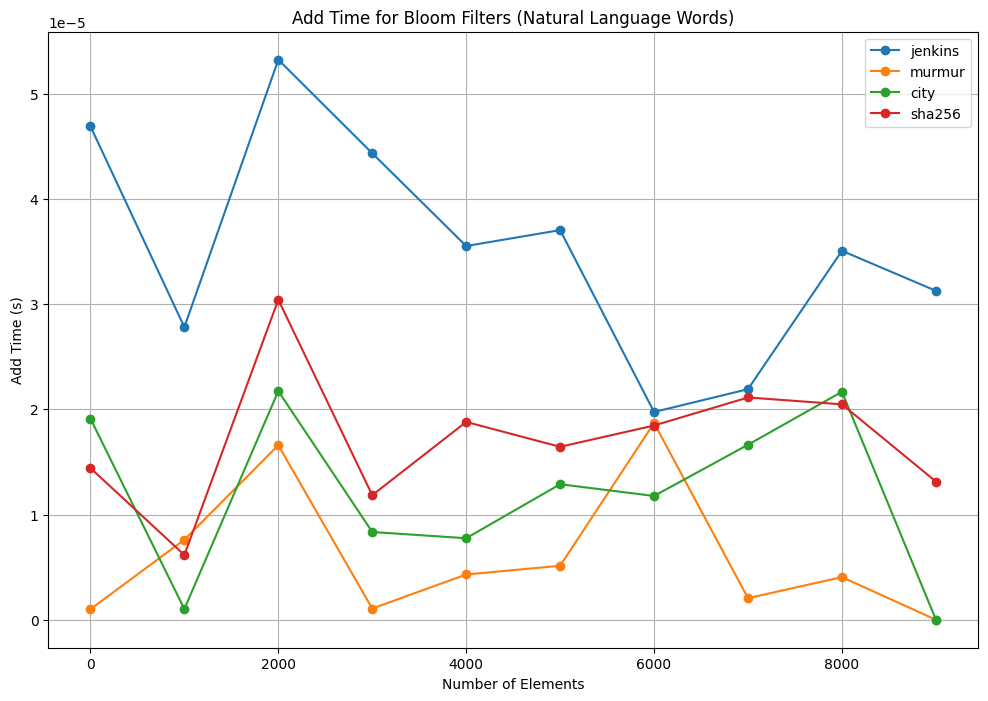

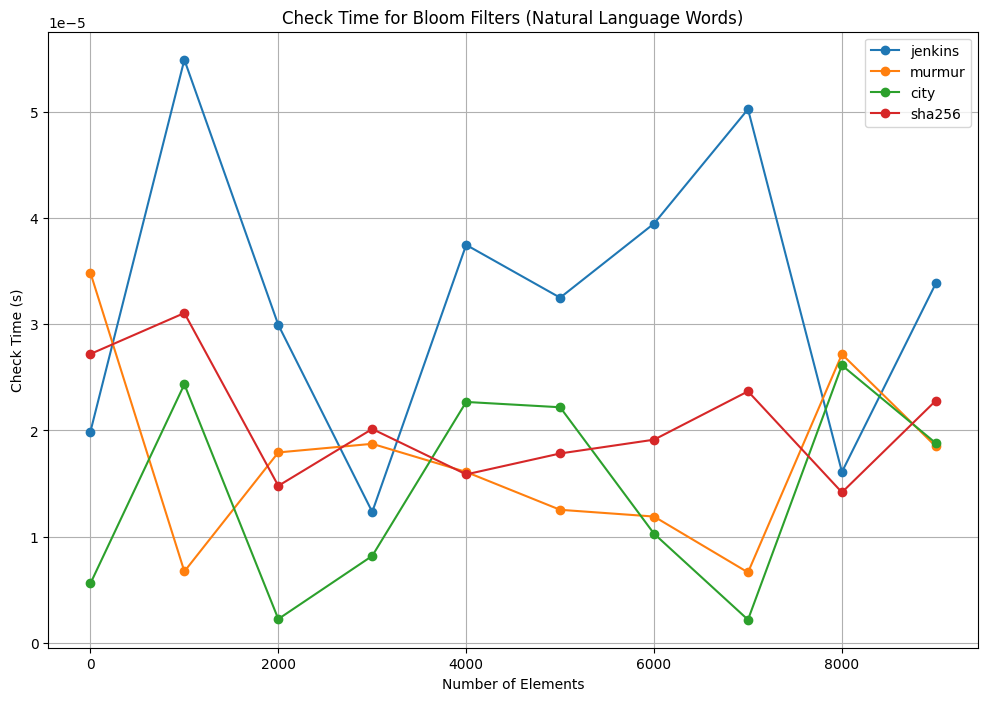

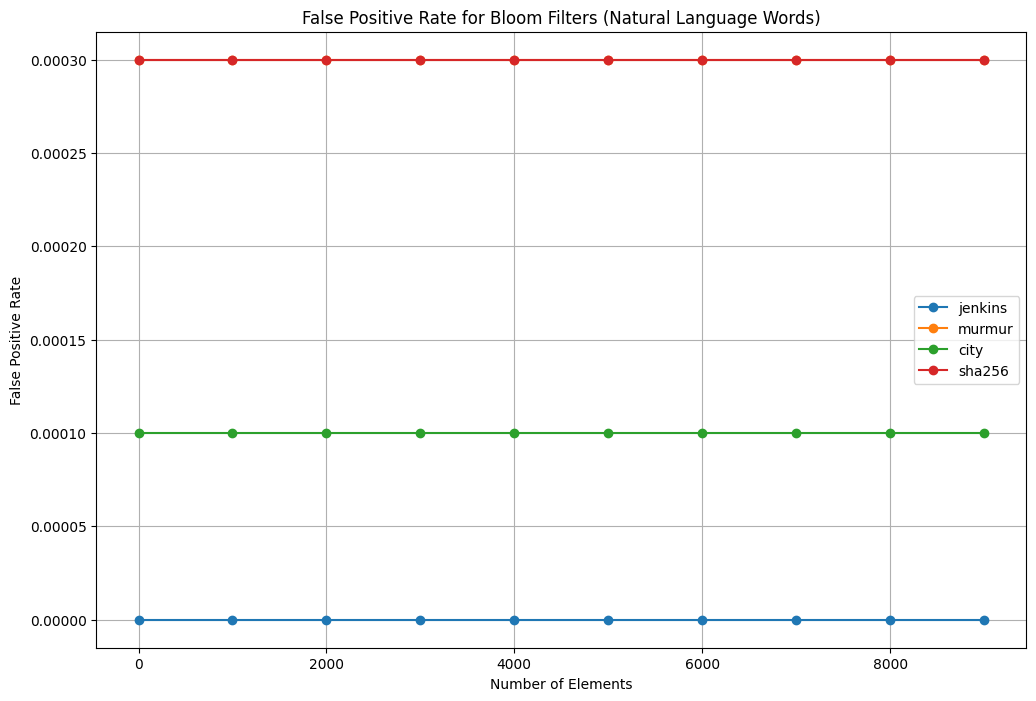

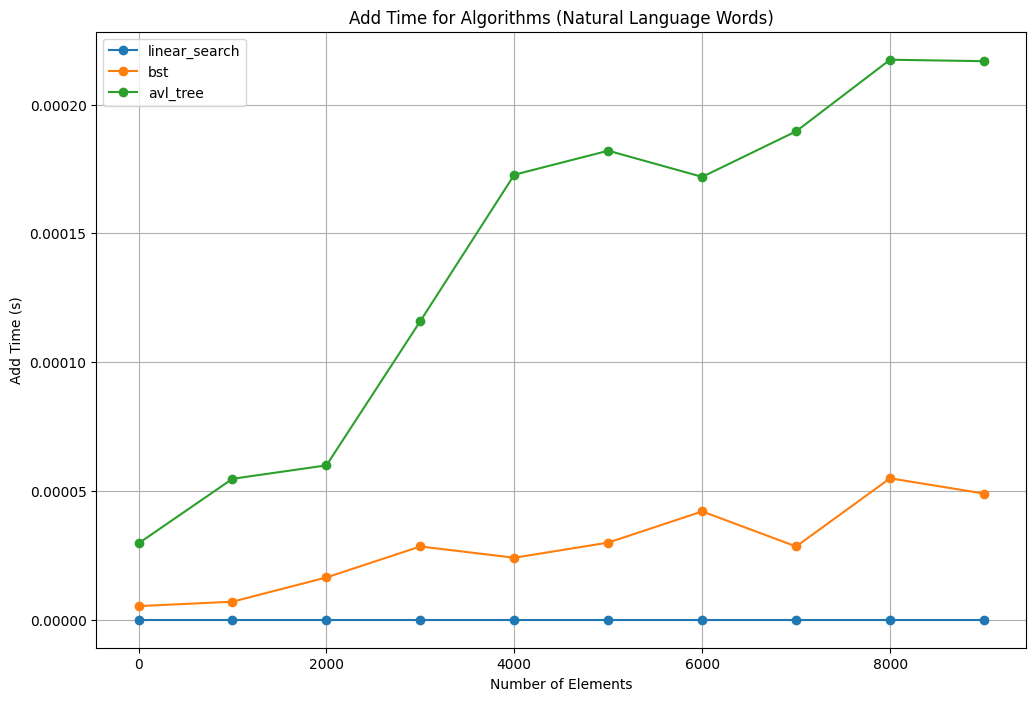

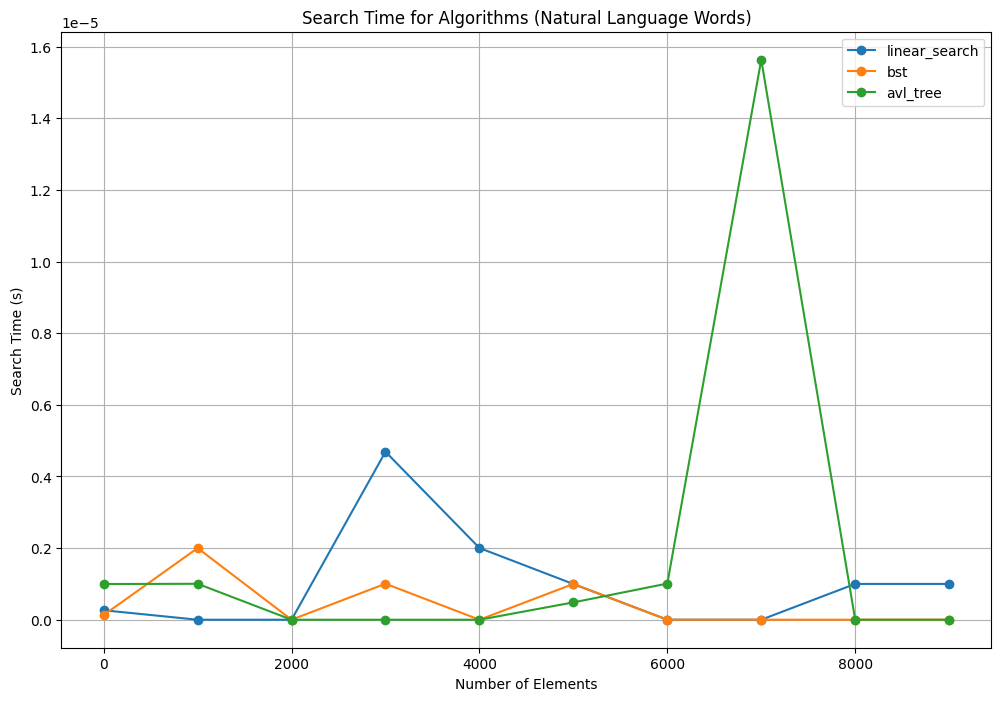

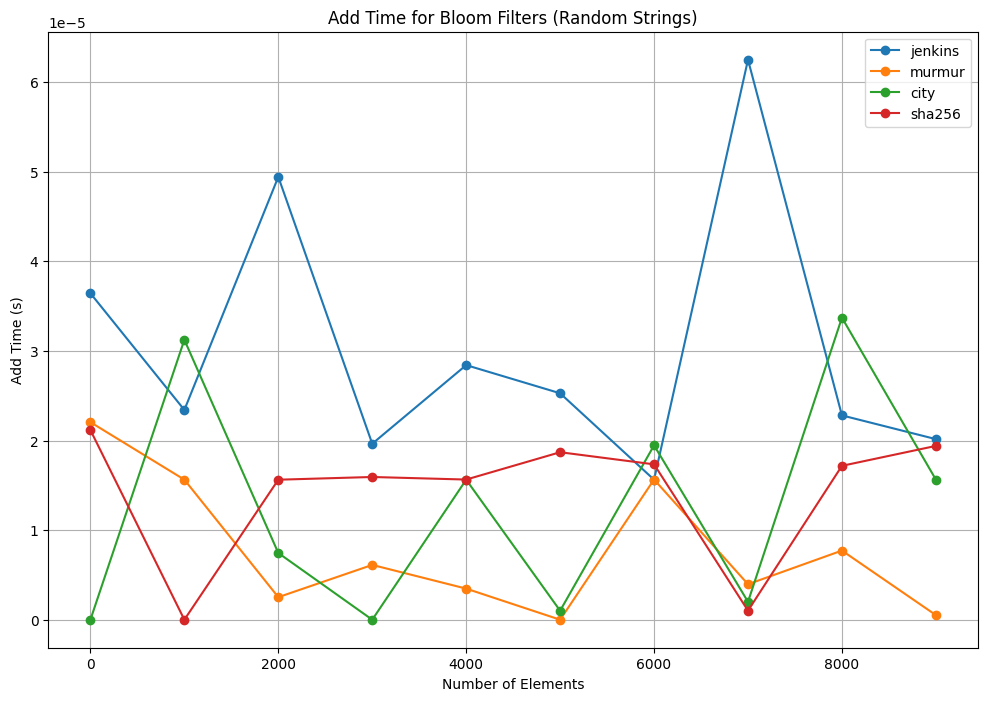

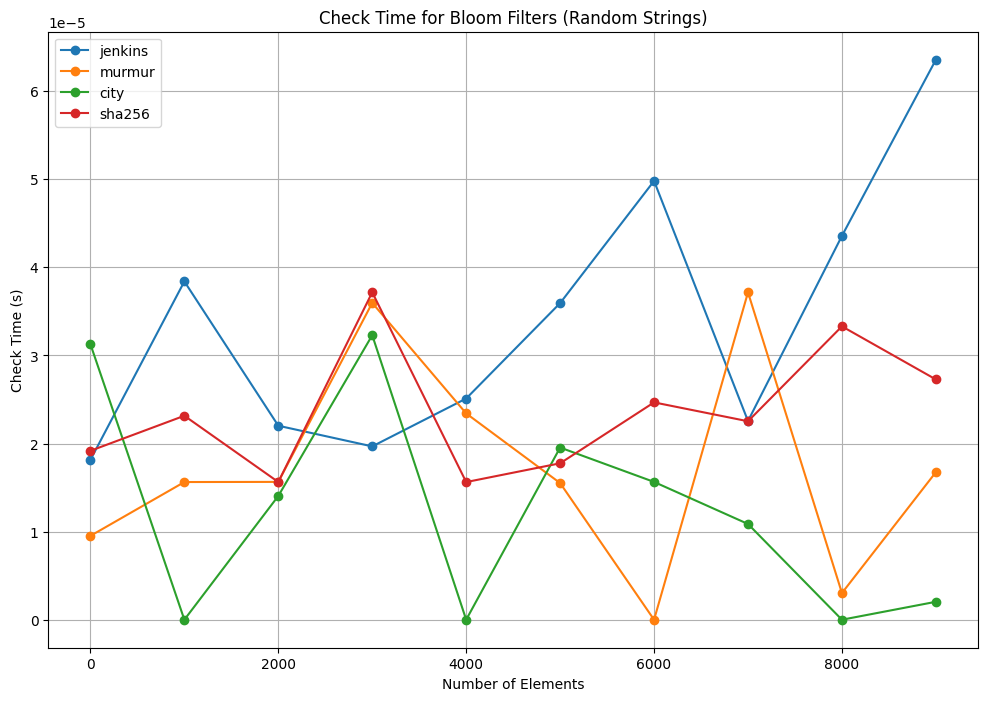

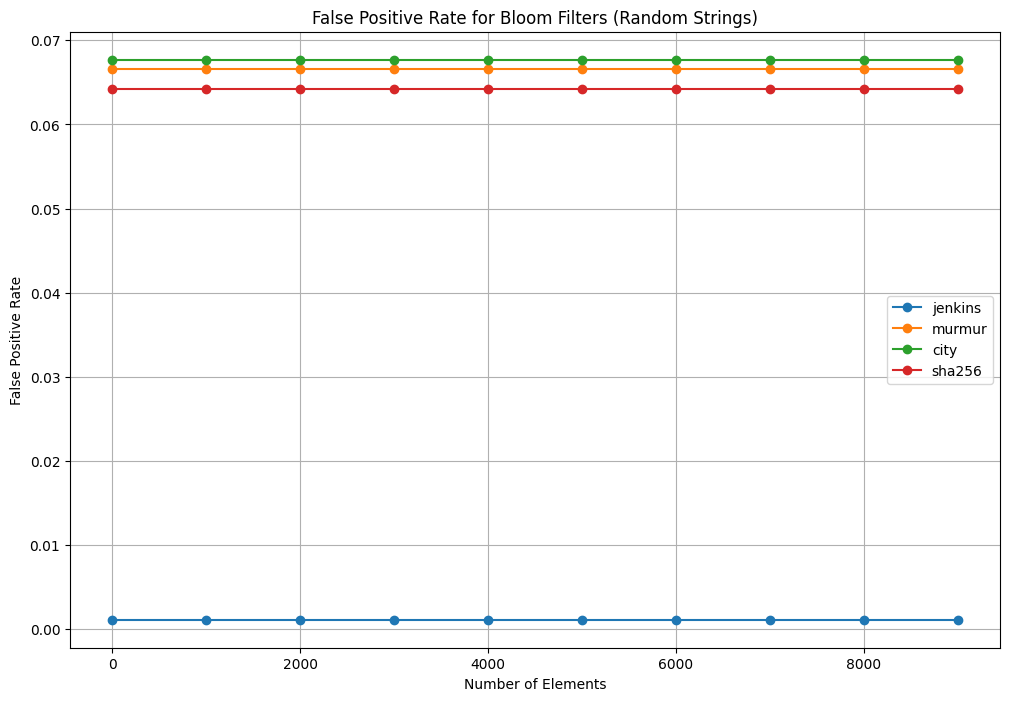

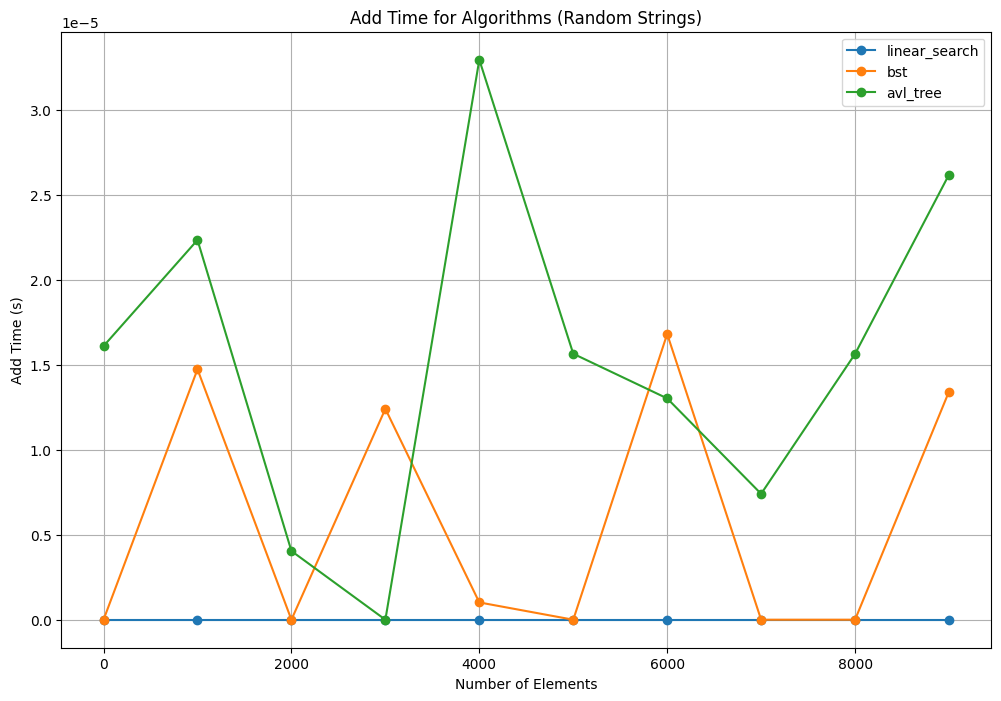

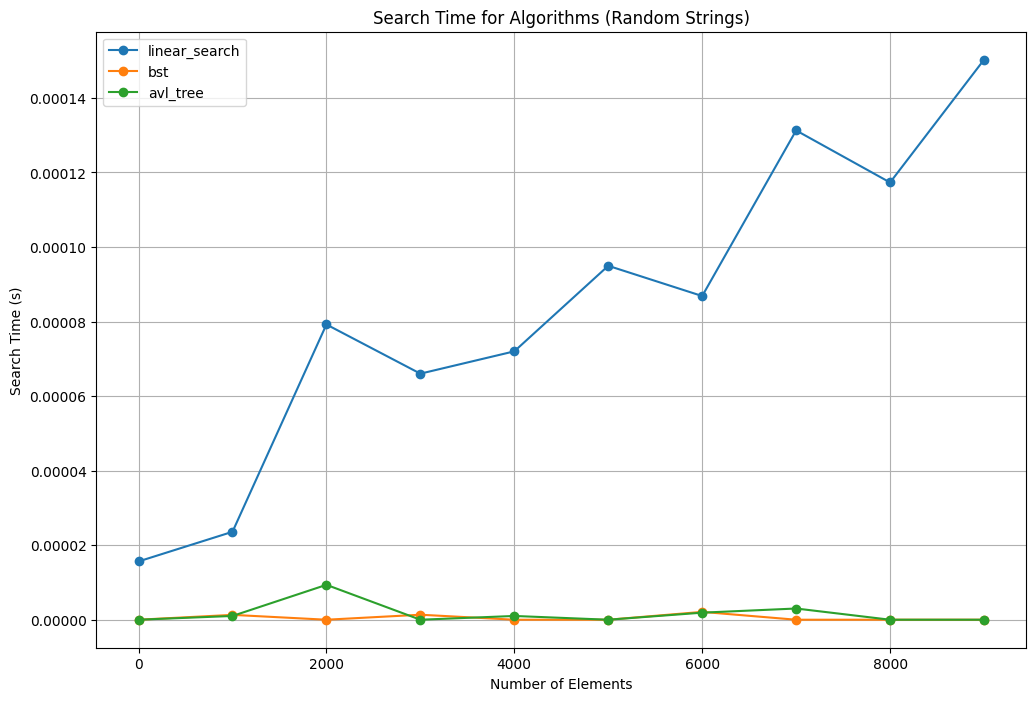

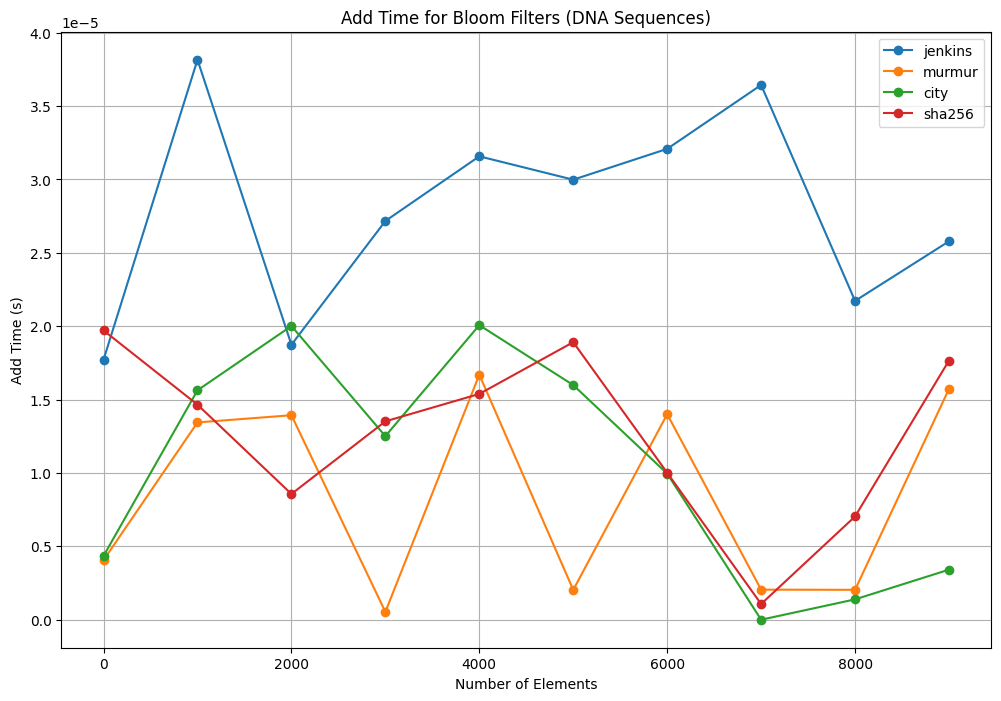

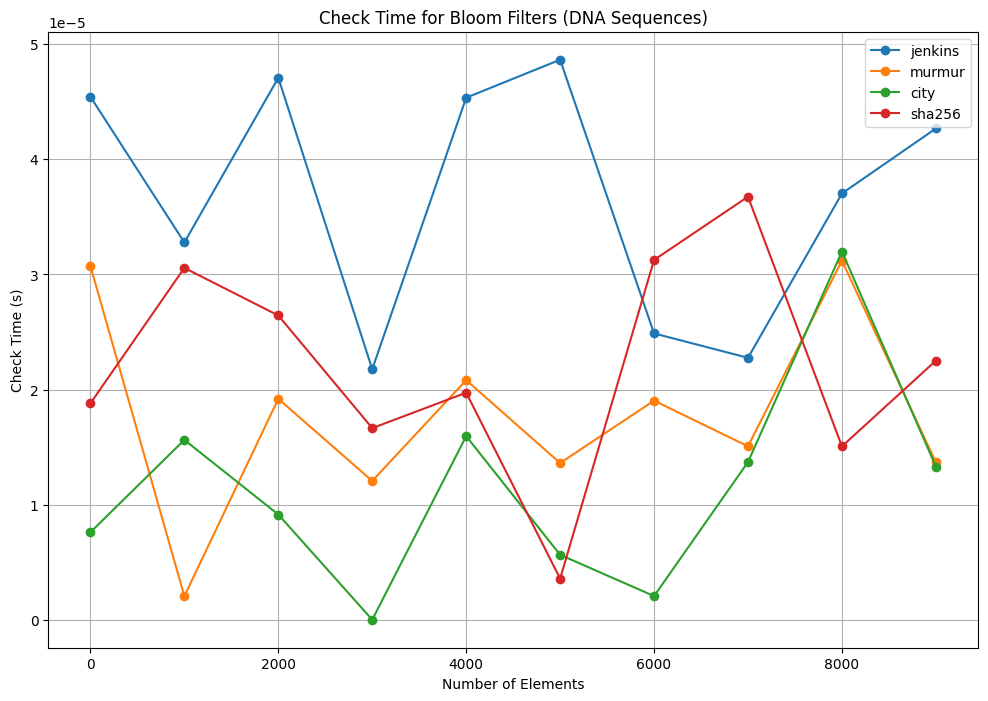

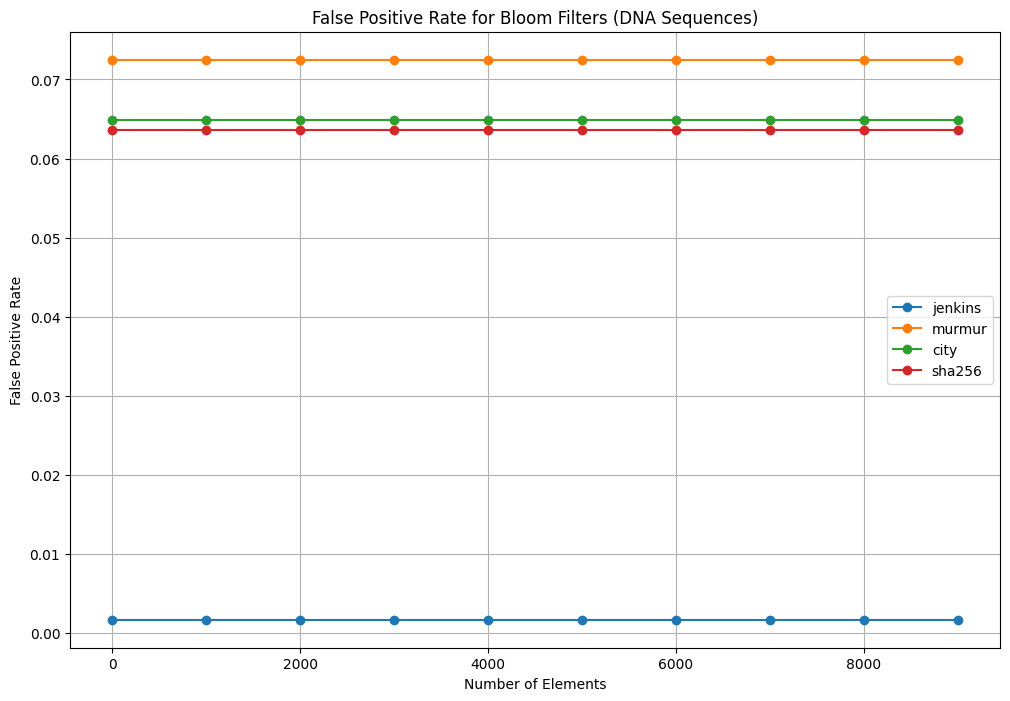

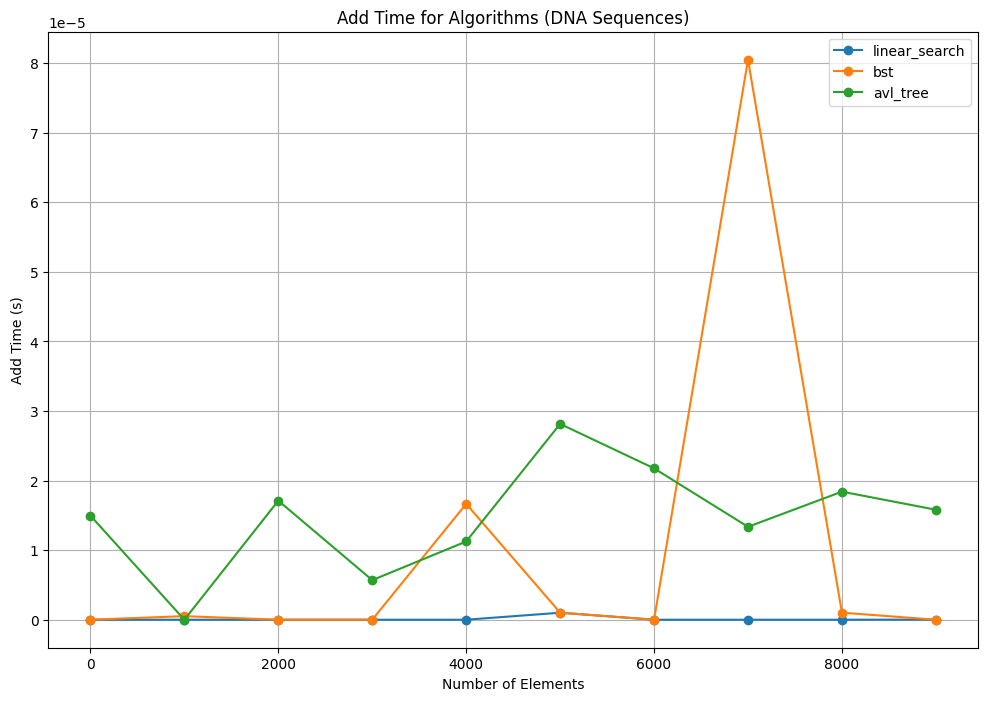

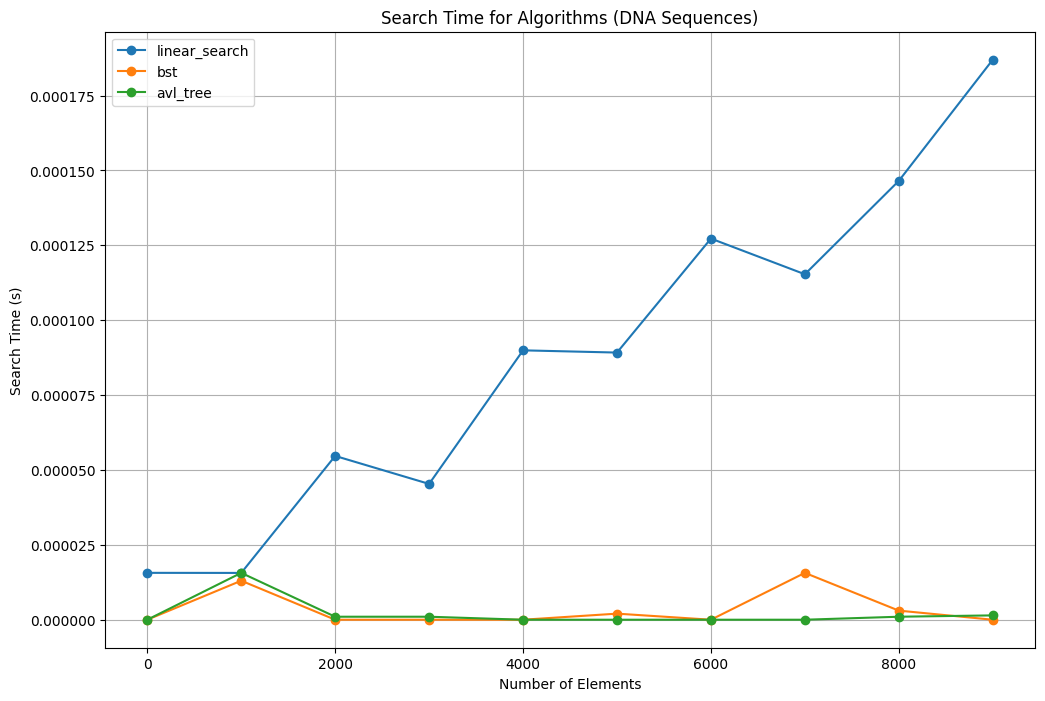

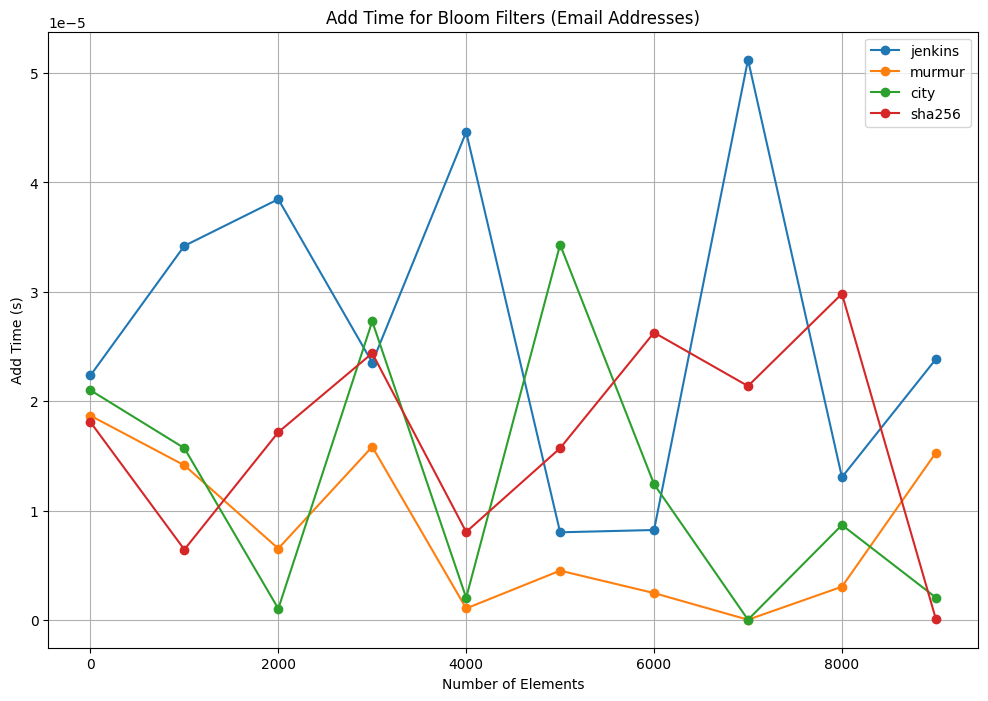

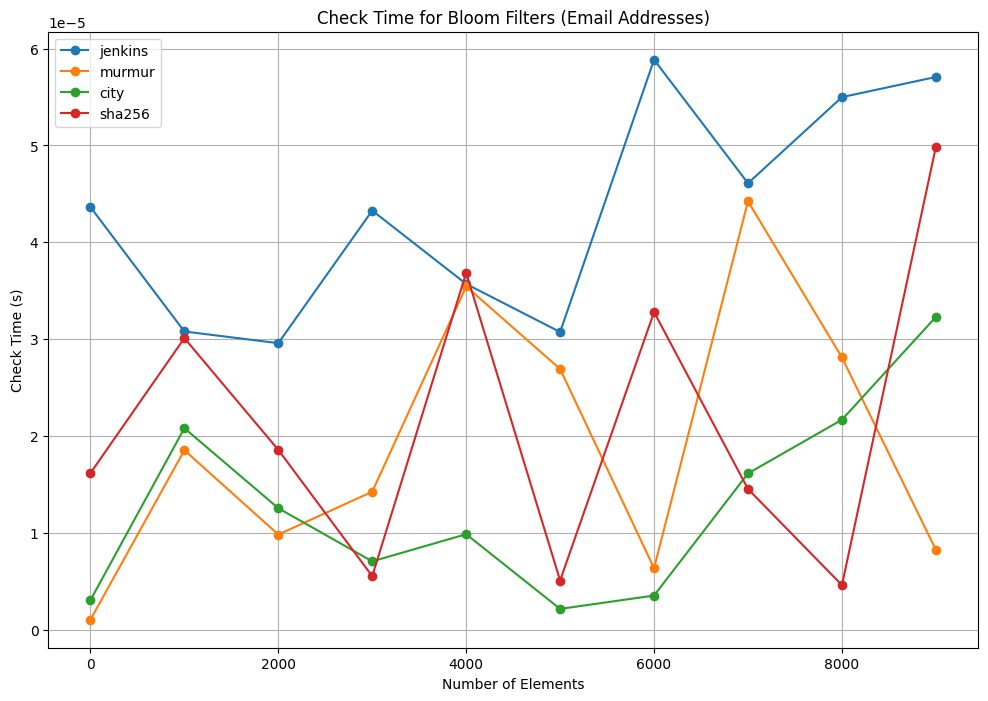

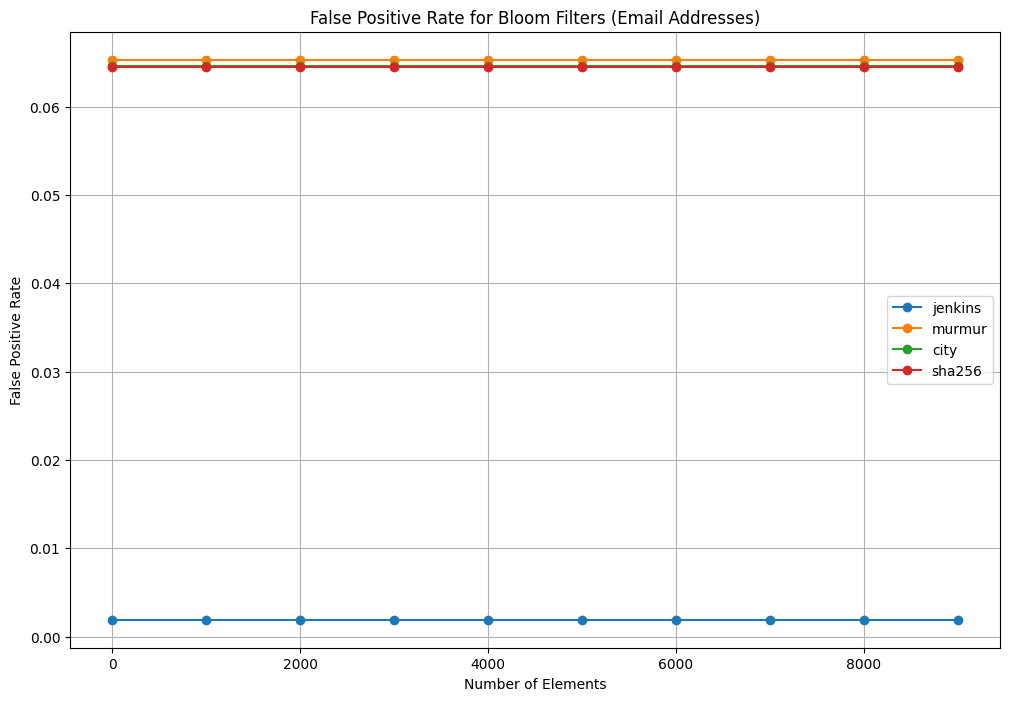

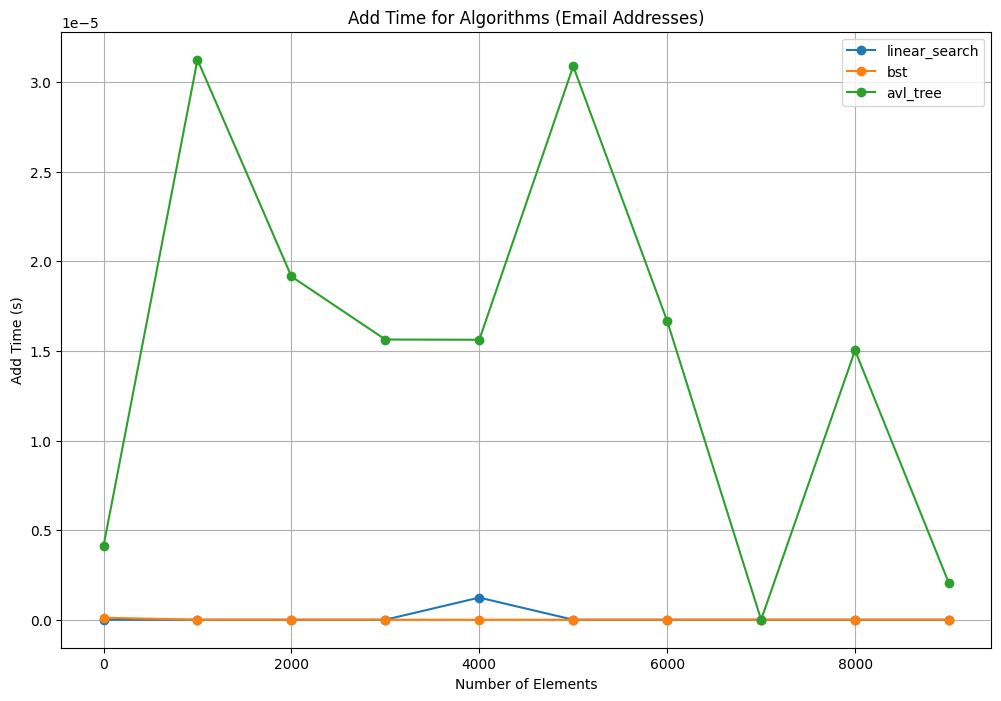

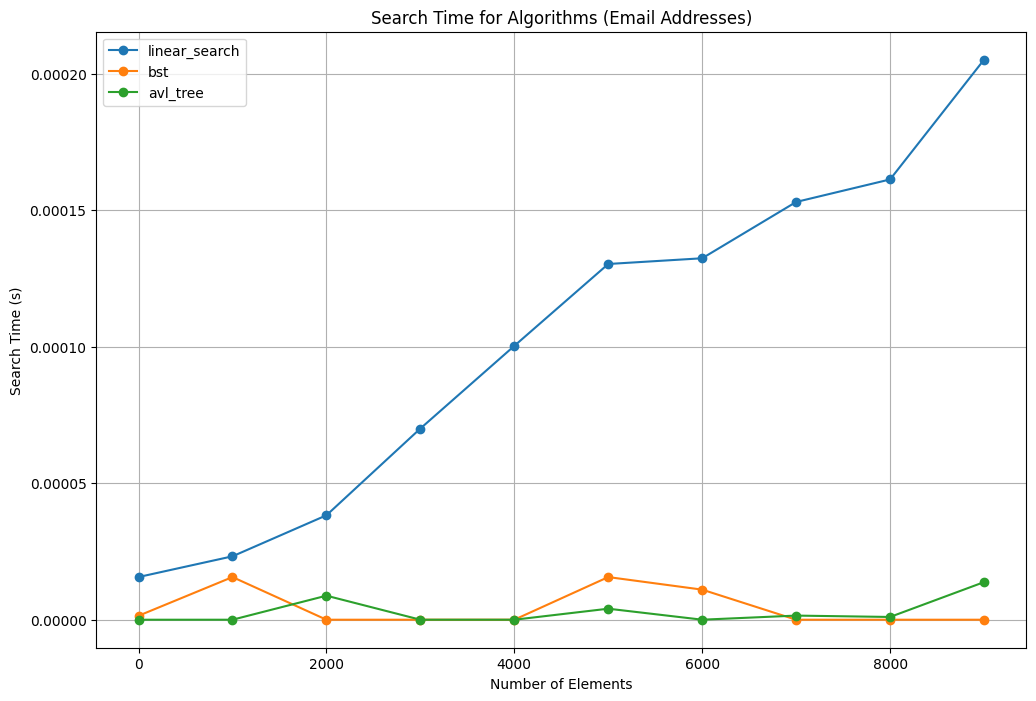

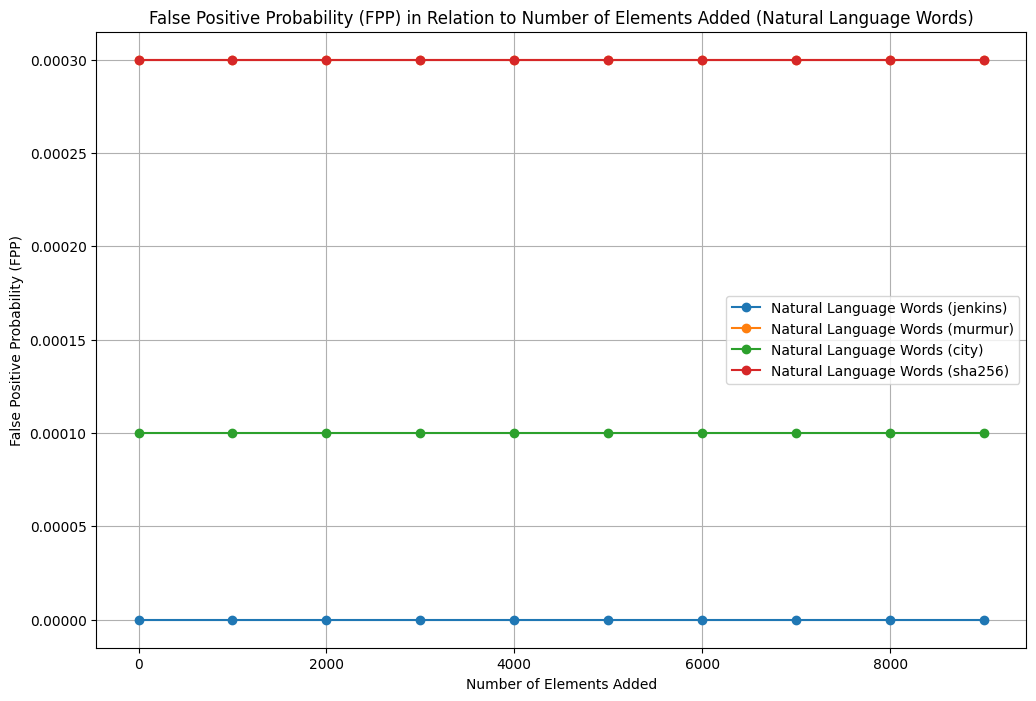

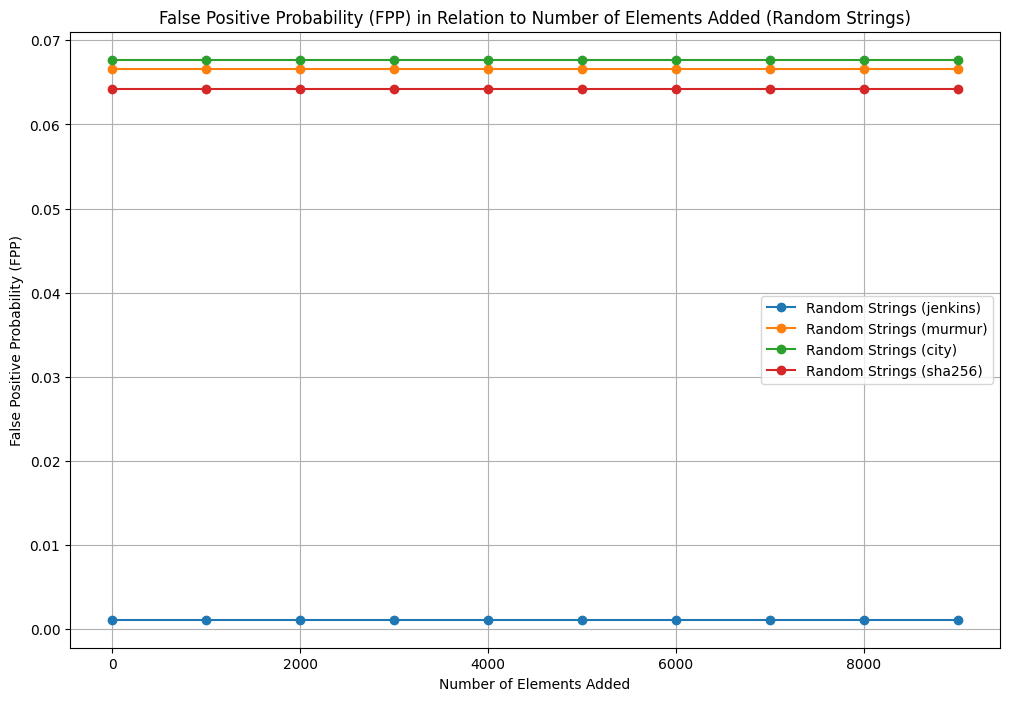

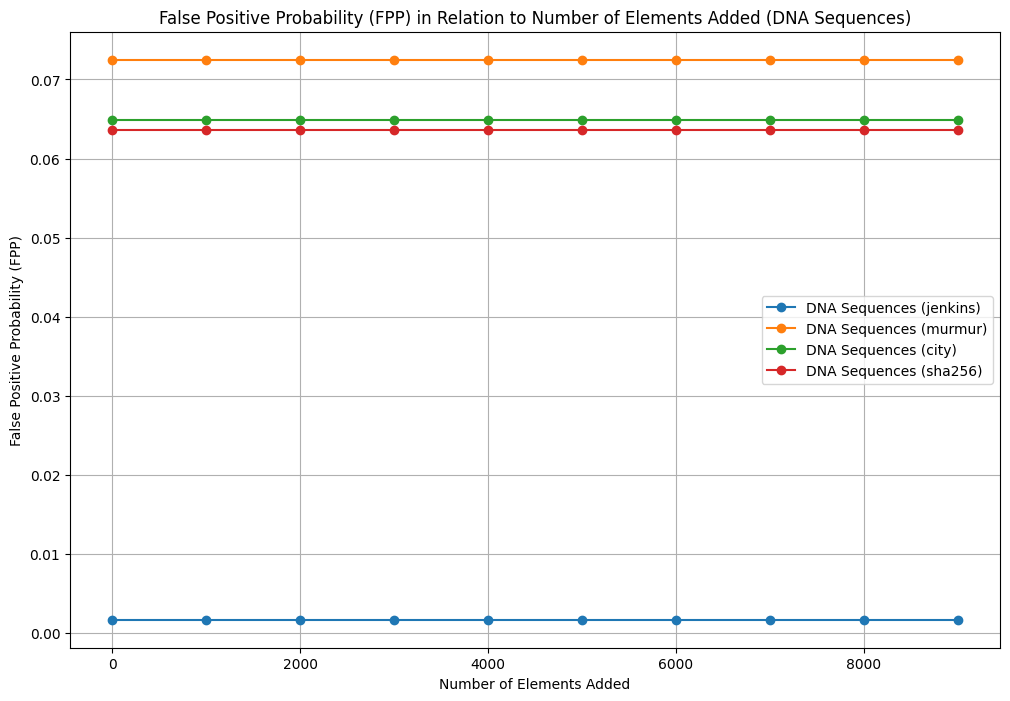

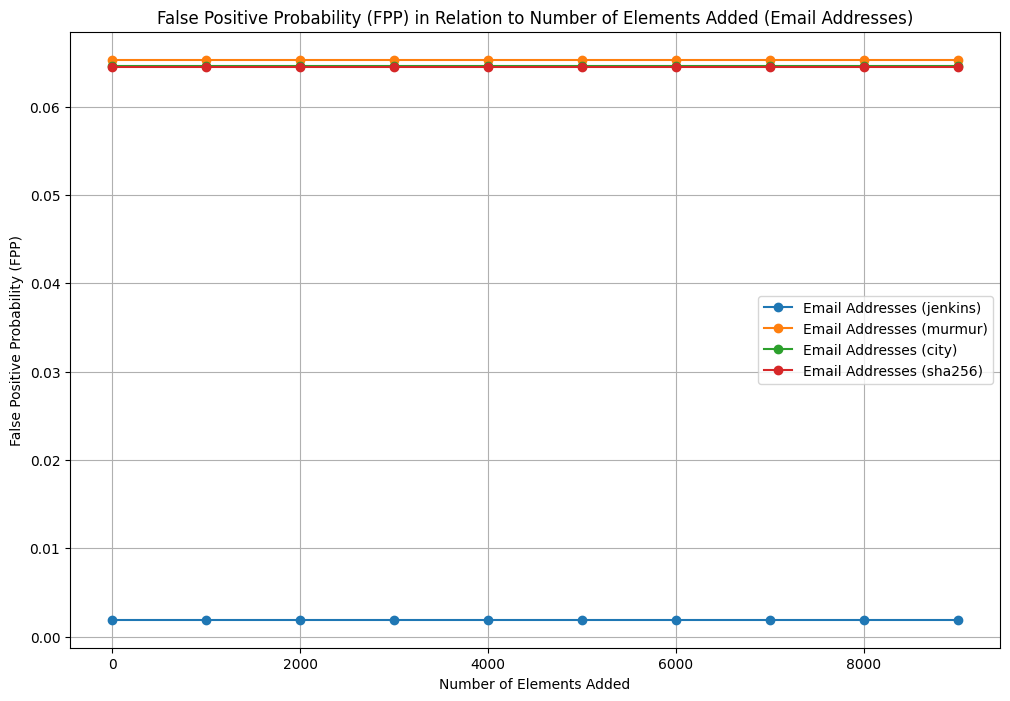

In [16]:
import json
import matplotlib.pyplot as plt
import numpy as np

GROUP_SIZE = 1000  # Define the group size for averaging

def plot_bloom_filter_metrics(results, data_type, metric, y_label):
    grouped_data = {}
    for hash_function in results[data_type]["bloom_filter"]:
        values = results[data_type]["bloom_filter"][hash_function][metric]
        grouped_data[hash_function] = [values[i:i + GROUP_SIZE] for i in range(0, len(values), GROUP_SIZE)]

    plt.figure(figsize=(12, 8))

    for hash_function, groups in grouped_data.items():
        mean_values = [np.mean(group) for group in groups]
        x_positions = range(0, len(mean_values) * GROUP_SIZE, GROUP_SIZE)

        plt.plot(x_positions, mean_values, marker='o', linestyle='-', label=f"{hash_function}")

    plt.title(f"{metric.replace('_', ' ').title()} for Bloom Filters ({data_type})")
    plt.xlabel("Number of Elements")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/{data_type}_bloom_filter_{metric}.png")
    plt.show()

def plot_algorithm_metrics(results, data_type, metric, y_label):
    grouped_data = {
        "linear_search": [results[data_type]["linear_search"][metric][i:i + GROUP_SIZE] for i in range(0, len(results[data_type]["linear_search"][metric]), GROUP_SIZE)],
        "bst": [results[data_type]["bst"][metric][i:i + GROUP_SIZE] for i in range(0, len(results[data_type]["bst"][metric]), GROUP_SIZE)],
        "avl_tree": [results[data_type]["avl_tree"][metric][i:i + GROUP_SIZE] for i in range(0, len(results[data_type]["avl_tree"][metric]), GROUP_SIZE)]
    }

    plt.figure(figsize=(12, 8))

    for algorithm, groups in grouped_data.items():
        mean_values = [np.mean(group) for group in groups]
        x_positions = range(0, len(mean_values) * GROUP_SIZE, GROUP_SIZE)

        plt.plot(x_positions, mean_values, marker='o', linestyle='-', label=f"{algorithm}")

    plt.title(f"{metric.replace('_', ' ').title()} for Algorithms ({data_type})")
    plt.xlabel("Number of Elements")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/{data_type}_algorithms_{metric}.png")
    plt.show()

def plot_false_positive_prob(results):
    for data_type in results:
        grouped_data = {}
        for hash_function in results[data_type]["bloom_filter"]:
            false_positive_rate = results[data_type]["bloom_filter"][hash_function]["false_positive_rate"]
            key = f"{data_type} ({hash_function})"
            grouped_data[key] = [false_positive_rate[i:i + GROUP_SIZE] for i in range(0, len(false_positive_rate), GROUP_SIZE)]

        plt.figure(figsize=(12, 8))

        for label, groups in grouped_data.items():
            mean_values = [np.mean(group) for group in groups]
            x_positions = range(0, len(mean_values) * GROUP_SIZE, GROUP_SIZE)

            plt.plot(x_positions, mean_values, marker='o', linestyle='-', label=label)

        plt.title(f"False Positive Probability (FPP) in Relation to Number of Elements Added ({data_type})")
        plt.xlabel("Number of Elements Added")
        plt.ylabel("False Positive Probability (FPP)")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"results/false_positive_prob_elements_{data_type}.png")
        plt.show()

def main():
    with open("results/benchmark_results.json", "r") as file:
        results = json.load(file)

    for data_type in results:
        plot_bloom_filter_metrics(results, data_type, "add_time", "Add Time (s)")
        plot_bloom_filter_metrics(results, data_type, "check_time", "Check Time (s)")
        plot_bloom_filter_metrics(results, data_type, "false_positive_rate", "False Positive Rate")
        plot_algorithm_metrics(results, data_type, "add_time", "Add Time (s)")
        plot_algorithm_metrics(results, data_type, "search_time", "Search Time (s)")

    plot_false_positive_prob(results)

if __name__ == "__main__":
    main()


## Analysis for Questions 7 and 8

We perform a detailed analysis to check how the false positive rate changes as the number of elements in the Bloom Filter increases and how the compression rate varies with different expected and observed false positive rates.


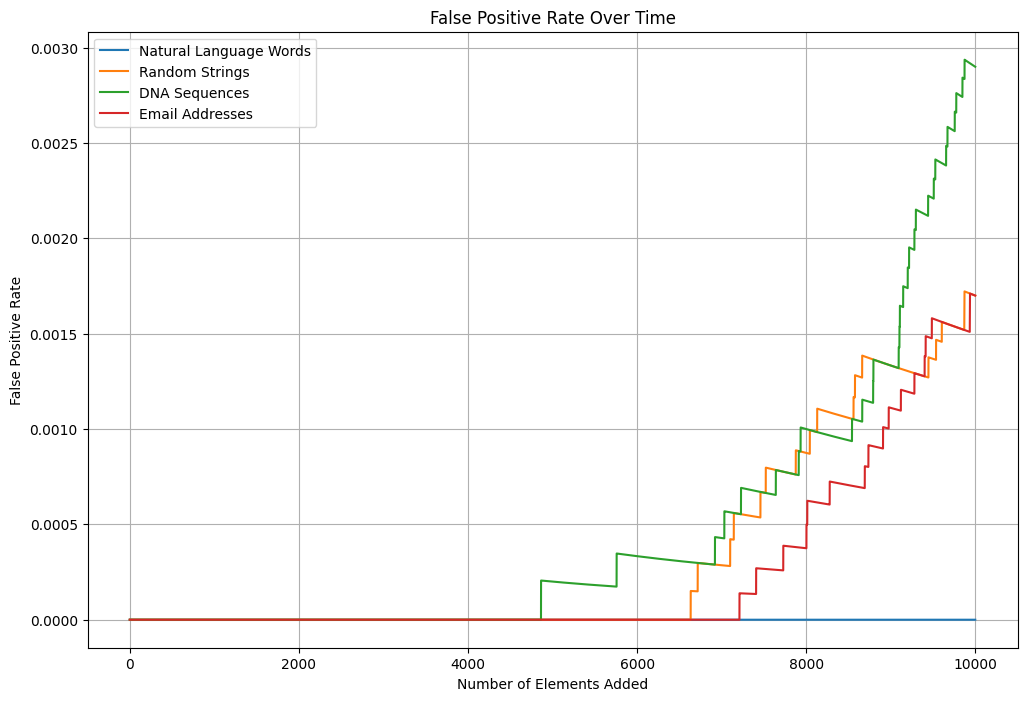

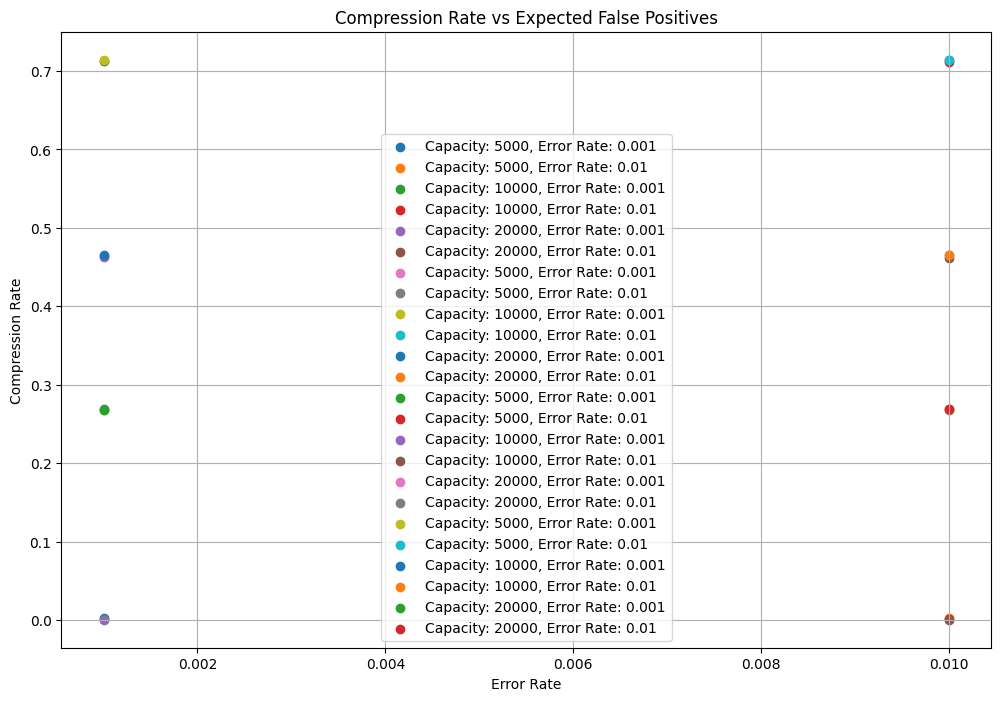

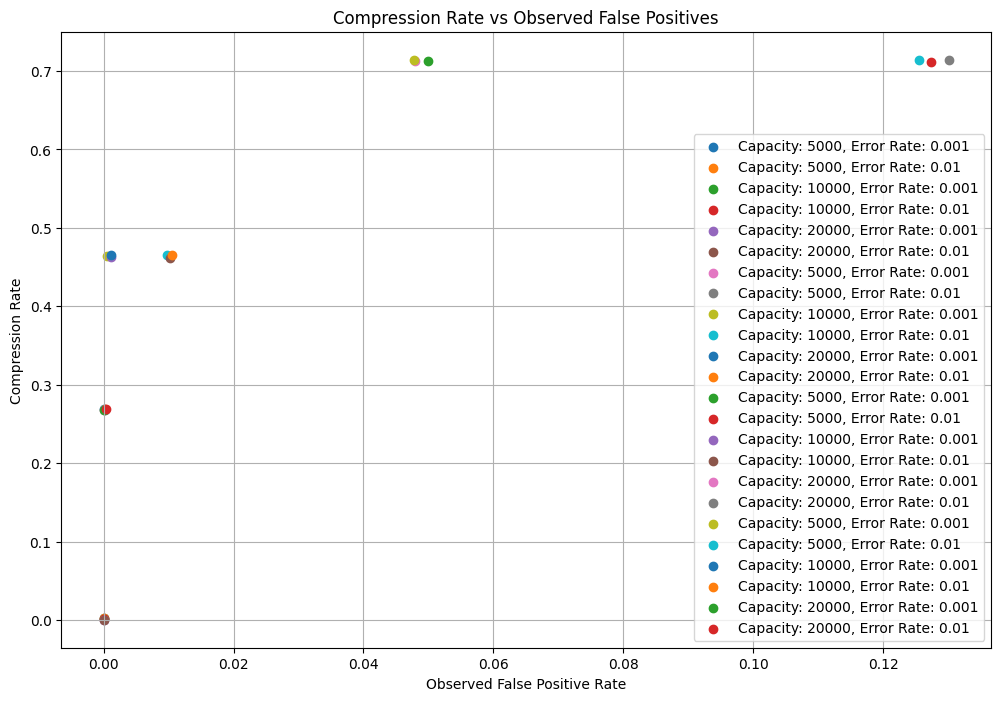

In [17]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

GROUP_SIZE = 1000  # Define the group size for averaging

def random_string(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

def analyze_false_positive_rate(data, capacity, error_rate, hash_function='jenkins'):
    bf = BloomFilter(capacity, error_rate, hash_function)

    false_positive_rates = []
    false_positives = 0

    for i, item in enumerate(data):
        bf.add(item)
        if bf.contains(random_string()):
            false_positives += 1

        false_positive_rate = false_positives / (i + 1)
        false_positive_rates.append(false_positive_rate)

    return false_positive_rates

def analyze_compression_rate(data, capacities, error_rates, hash_function='jenkins'):
    results = []

    for capacity in capacities:
        for error_rate in error_rates:
            bf = BloomFilter(capacity, error_rate, hash_function)
            for item in data:
                bf.add(item)

            actual_bit_usage = sum(bin(x).count('1') for x in bf.bitset.bitset)
            compression_rate = actual_bit_usage / bf.bitset.size

            false_positives = 0
            for _ in range(10000):  # Test with 10,000 random strings
                if bf.contains(random_string()):
                    false_positives += 1

            observed_false_positive_rate = false_positives / 10000

            results.append({
                'capacity': capacity,
                'error_rate': error_rate,
                'compression_rate': compression_rate,
                'observed_false_positive_rate': observed_false_positive_rate
            })

    return results

def plot_false_positive_rate(results, title):
    plt.figure(figsize=(12, 8))
    for label, rates in results.items():
        plt.plot(rates, label=label)
    plt.title(title)
    plt.xlabel("Number of Elements Added")
    plt.ylabel("False Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/{title.replace(' ', '_').lower()}.png")
    plt.show()

def plot_compression_rate(results, title, x_key, y_key):
    plt.figure(figsize=(12, 8))
    for result in results:
        plt.scatter(result[x_key], result[y_key], label=f"Capacity: {result['capacity']}, Error Rate: {result['error_rate']}")
    plt.title(title)
    plt.xlabel(x_key.replace('_', ' ').title())
    plt.ylabel(y_key.replace('_', ' ').title())
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/{title.replace(' ', '_').lower()}.png")
    plt.show()

# Main analysis code
capacity = 10000
error_rate = 0.01
num_elements = 15000  # Exceed the designed capacity to test false positive rate changes

data_files = {
    "Natural Language Words": "data/natural_language_words.txt",
    "Random Strings": "data/random_strings.txt",
    "DNA Sequences": "data/dna_sequences.txt",
    "Email Addresses": "data/email_addresses.txt"
}

results_q7 = {}
results_q8 = []

os.makedirs("results", exist_ok=True)

for data_type, file_path in data_files.items():
    data = load_data(file_path)[:num_elements]  # Limit data to num_elements

    # Question 7: False Positive Rate Analysis
    results_q7[data_type] = analyze_false_positive_rate(data, capacity, error_rate, hash_function='jenkins')

    # Question 8: Compression Rate Analysis
    capacities = [5000, 10000, 20000]
    error_rates = [0.001, 0.01]
    results_q8.extend(analyze_compression_rate(data, capacities, error_rates, hash_function='jenkins'))

# Plot results for Question 7
plot_false_positive_rate(results_q7, "False Positive Rate Over Time")

# Plot results for Question 8
plot_compression_rate(results_q8, "Compression Rate vs Expected False Positives", 'error_rate', 'compression_rate')
plot_compression_rate(results_q8, "Compression Rate vs Observed False Positives", 'observed_false_positive_rate', 'compression_rate')

# Save results to JSON for further inspection
with open("results/q7_results.json", "w") as file:
    json.dump(results_q7, file, indent=4)

with open("results/q8_results.json", "w") as file:
    json.dump(results_q8, file, indent=4)
